In [95]:
import os
import json
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import ee
import datetime
from shapely.geometry import Polygon, mapping, box
import numpy as np
import rasterio

Initialising shapes and EE

In [3]:
ee.Authenticate()
ee.Initialize(project='ee-varunkhandekar')
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


In [71]:
shapefile_path = '/home/vkhandekar/project_flood/static/bangladesh-outline_68.geojson'
with open(shapefile_path, 'r') as file:
    geojson_data = json.load(file)

polygon_coordinates = []

for feature in geojson_data['features']:
    if feature['geometry']['type'] == 'Polygon':
        polygon_coordinates.append(feature['geometry']['coordinates'])
    elif feature['geometry']['type'] == 'MultiPolygon':
        for polygon in feature['geometry']['coordinates']:
            polygon_coordinates.append(polygon)

ee_geometry = ee.Geometry.MultiPolygon(polygon_coordinates)
polygon = Polygon(polygon_coordinates[0][0])

# print(polygon.bounds)
# print(ee_geometry.bounds().getInfo())
bbox_ee = ee.Geometry.BBox(*polygon.bounds)
bbox = box(*polygon.bounds)
geojson = [mapping(bbox)]

with open('/home/vkhandekar/project_flood/static/local_core_paths.json') as core_config_file:
# with open(os.environ["PROJECT_FLOOD_CORE_PATHS"]) as core_config_file:
    core_config = json.load(core_config_file)


with open('/home/vkhandekar/project_flood/static/local_data_paths.json') as data_config_file:
# with open(os.environ["PROJECT_FLOOD_DATA_PATHS"]) as core_config_file:
    data_config = json.load(data_config_file)

Flood distribution over time

/tmp/ipykernel_1001550/1669900966.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range('2024-01-01', periods=12, freq='M').strftime('%B'))


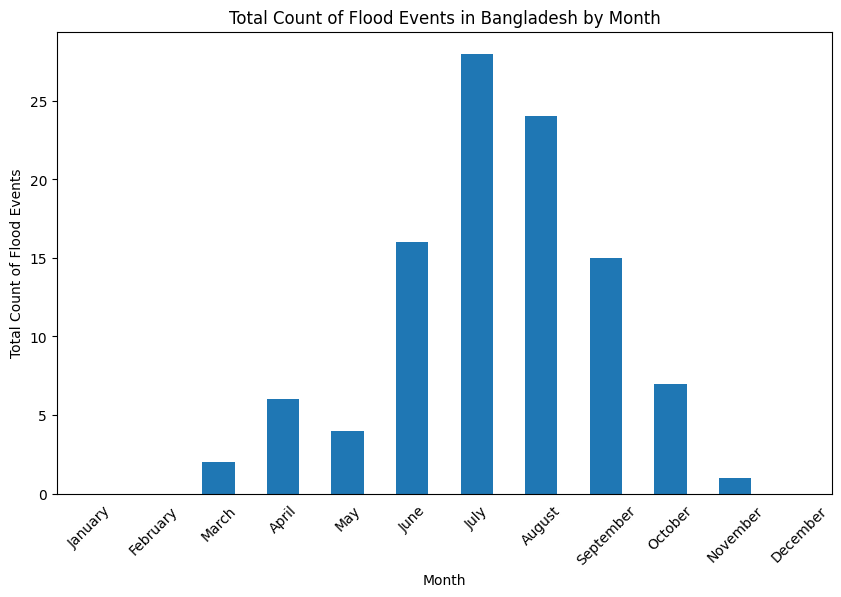

In [4]:
floods_file_path = core_config["flood_events"]
floods = pd.read_excel(floods_file_path)

floods['month_name'] = floods['dfo_began_uk'].dt.strftime('%B')

# Count the number of events per month name, summing across all years
monthly_event_counts_across_years = floods['month_name'].value_counts().reindex(
    pd.date_range('2024-01-01', periods=12, freq='M').strftime('%B'))

# Plot the bar chart
plt.figure(figsize=(10, 6))
monthly_event_counts_across_years.plot(kind='bar')
plt.title('Total Count of Flood Events in Bangladesh by Month')
plt.xlabel('Month')
plt.ylabel('Total Count of Flood Events')
plt.xticks(rotation=45)
plt.grid(False)  # Remove gridlines
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)  # Remove x-tick marks

output_file_name = os.path.join(data_config['project_report_visuals'], 'bangladesh_flood_distribution.png')
plt.savefig(output_file_name, bbox_inches='tight')
plt.show()

Soil moisture average by month

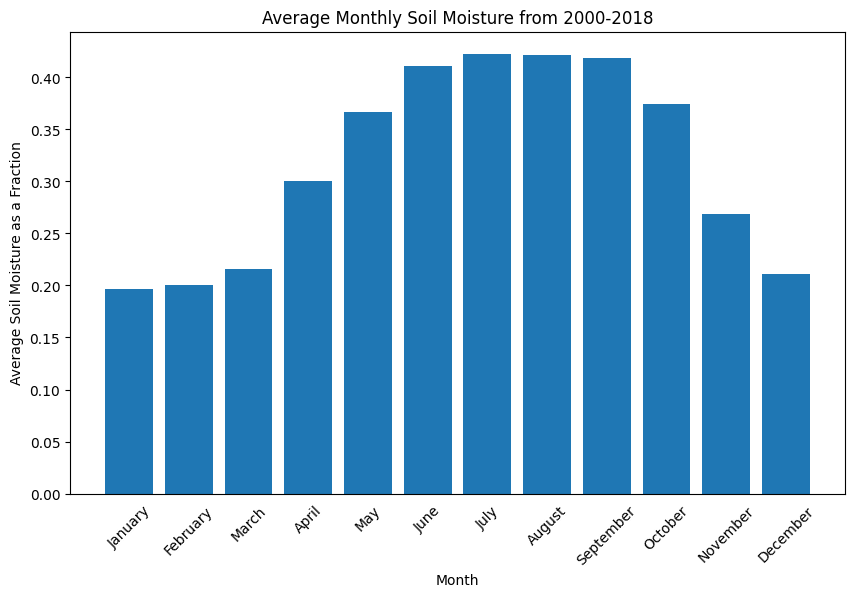

In [127]:
# Define the date range for the analysis
start_date = '2000-02-17'
end_date = '2018-12-10'

monthly_dataset = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR').filterDate(start_date, end_date)
soil_moisture_monthly = monthly_dataset.select('volumetric_soil_water_layer_1')

def extract_month(image):
    date = ee.Date(image.get('system:time_start'))
    month = date.get('month')
    return image.set('month', month)

soil_moisture_by_month = soil_moisture_monthly.map(extract_month)

def calculate_monthly_mean(month):
    filtered = soil_moisture_by_month.filter(ee.Filter.eq('month', month))
    return filtered.mean().set('month', month)

monthly_averages = ee.ImageCollection([calculate_monthly_mean(month) for month in range(1, 13)])
clipped_monthly_averages = monthly_averages.map(lambda image: image.clip(bbox_ee))

def reduce_and_mean(image):
    mean_value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=bbox_ee, scale=1000)
    return image.set('mean_value', mean_value.get('volumetric_soil_water_layer_1'))

final_means = clipped_monthly_averages.map(reduce_and_mean)
data = final_means.getInfo()

months_full = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
moisture_values = [entry['properties']['mean_value'] for entry in data['features']]

plt.figure(figsize=(10, 6))
plt.bar(months_full, moisture_values)
plt.title('Average Monthly Soil Moisture from 2000-2018')
plt.xlabel('Month')
plt.ylabel('Average Soil Moisture as a Fraction')
plt.xticks(rotation=45)
plt.grid(False)  # Remove gridlines
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)  # Remove x-tick marks

output_file_name = os.path.join(data_config['project_report_visuals'], 'bangladesh_monthly_soil_moisture.png')
plt.savefig(output_file_name, bbox_inches='tight')
plt.show()

Soil moisture average gridded

In [97]:
# for i in range(monthly_averages.size().getInfo()):
#     image = ee.Image(monthly_averages.toList(monthly_averages.size()).get(i))
#     task = ee.batch.Export.image.toDrive(
#         image=image,
#         description=f"soil_moisture_{i}",
#         folder='Visualisations_project_flood',
#         fileNamePrefix=f"soil_moisture_{i}",
#         region=bbox_ee,
#         crs='EPSG:4326',
#         crsTransform=[0.0226492347869873, 0.0, 88.08430518433968, 0.0, -0.0226492347869873, 26.44864775268901]
#     )
#     task.start()

filepath = f"{data_config['project_report_visuals']}/soil_moisture"
def extract_month_number(filename):
    return int(filename.split('_')[-1].split('.')[0])
tif_files = sorted(os.listdir(filepath), key=extract_month_number)

      

/tmp/ipykernel_29093/1016503861.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


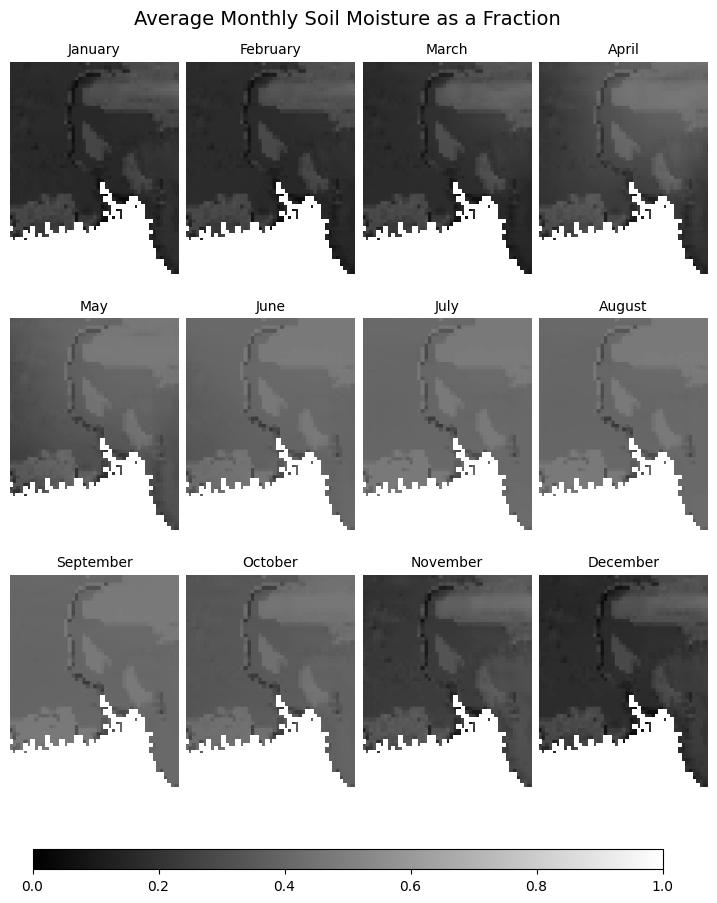

In [136]:
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

n_rows = 3
n_cols = 4

fig = plt.figure(figsize=(9, 10))

gs = GridSpec(n_rows, n_cols, figure=fig, wspace=0.05, hspace=0)

# Second pass to plot the data
for i, (file, month) in enumerate(zip(tif_files, months)):
    ax = fig.add_subplot(gs[i])
    file = os.path.join(filepath, file)
    with rasterio.open(file) as src:
        data = src.read(1)
        im = ax.imshow(data, vmin=0, vmax=1, cmap='gray')
        ax.set_title(month, fontsize=10)
        # ax.set_aspect('auto')
        ax.axis('off')  # Hide the axes ticks

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

fig.suptitle("Average Monthly Soil Moisture as a Fraction", fontsize=14, y=0.91)
# fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.tight_layout()


output_file_name = os.path.join(data_config['project_report_visuals'], 'bangladesh_soil_moisture_grid.png')
plt.savefig(output_file_name, bbox_inches='tight')

plt.show()